In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings 
from scipy.stats import linregress 
import pickle
import sys
sys.path.append('../src/')
import preprocessing, data_manager, plot
from sklearn.metrics import mean_absolute_error

# PART A: Solar Production Data

Our goal here is to predict the energy production of the City of Calgary's various solar arrays, using publicly available weather data.

Lets start by taking a look at the hourly data prodived by the city 
(this data is available [here](https://data.calgary.ca/Environment/Solar-Energy-Production/ytdn-2qsp/about_data) ).

In [2]:
df_production = pd.read_csv('../data/Solar_Energy_Production_20250219.csv')
df_production.head()

,name,id,address,date,kWh,public_url,installationDate,uid
0,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 08:00:00 AM,1.130,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 08:00:00
1,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 09:00:00 AM,2.340,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 09:00:00
2,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 10:00:00 AM,3.656,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 10:00:00
3,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 11:00:00 AM,4.577,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 11:00:00
4,Calgary Fire Hall Headquarters,314106,1212 42 AV SE,2017/09/11 12:00:00 PM,6.506,https://monitoring.solaredge.com/solaredge-web...,2016/11/07,3141062017-09-11 12:00:00


Looks like the columns we'll be needing are `name`, `date`, `kWh` and `installationDate`. The `address` might also come in handy later. 

A few initial questions come to mind here. How many locations are there and is there data over the same time range for every location?
Lets also see how many unique values there are for `name`, which will tell us the names of each array location. We can then compare this with the `installationDate`, as well as the start and end dates of the data for each location.

In [3]:
dfp = df_production[["name","installationDate"]].groupby("name").max() 
dfp['Data Start'] = df_production[["name","date"]].groupby("name").min()['date'].values
dfp['Data End'] = df_production[["name","date"]].groupby("name").max()['date'].values

dfp

,installationDate,Data Start,Data End
name,,,
Bearspaw Water Treatment Plant,2017/10/31,2017/11/21 01:45:00 PM,2025/02/17 12:00:00 PM
CFD Firehall #7,2017/09/13,2017/09/21 01:00:00 PM,2025/02/17 12:00:00 PM
Calgary Fire Hall Headquarters,2016/11/07,2016/11/24 02:00:00 PM,2025/02/17 12:00:00 PM
City of Calgary North Corporate Warehouse,2016/12/21,2016/12/23 01:30:00 PM,2025/02/17 12:00:00 PM
Glenmore Water Treatment Plant,2017/01/11,2017/03/08 01:00:00 PM,2025/02/17 12:00:00 PM
Hillhurst Sunnyside Community Association,2016/09/25,2016/10/03 01:00:00 PM,2024/11/17 12:00:00 PM
Manchester Building M,2017/10/23,2017/10/05 01:15:00 PM,2025/02/17 12:00:00 PM
Richmond - Knob Hill Community Hall,2016/11/21,2016/12/09 01:00:00 PM,2025/02/17 12:00:00 PM
Southland Leisure Centre,2015/09/01,2015/09/01 02:30:00 PM,2025/02/17 12:00:00 PM


Seems like all the data starts *after* the installation date, which is a good sanity check!
From the start of 2018 all the locations are up and running, but it seems `Telus Spark` only has data until March 2018, so we should remove this location. 

Based on this it makes sense to use data from **January 1st 2018 to December 31st 2024**, giving us 7 years of data. This ensures we have equal amounts of data for each location and for each month of the year, making modelling much easier. 

In [4]:
# remove Telus Spark
df_production = df_production[df_production['name'] != 'Telus Spark']
# slice data from start of 2018 to end 2024
df_production['date'] = pd.to_datetime(df_production['date'])
df_production = df_production.set_index('date').sort_index()

df_production = df_production['20180101':'20241231']

Ok lets plot the **mean `kWh` production** at each location to get a sense of the size of each array. We'll also add some "error" bars to get a sense of the variability of the output (based on the standard deviation). 


<ErrorbarContainer object of 3 artists>

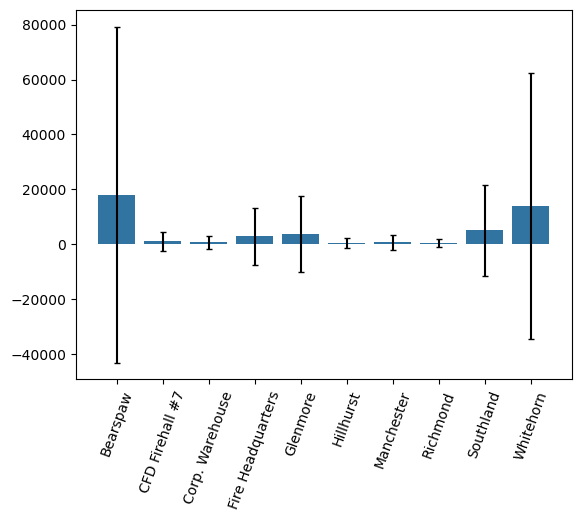

In [5]:

df_mean_output = df_production[["name","kWh"]].groupby("name").mean()
# add some error bars for the standard dev
df_std_output = df_production[["name","kWh"]].groupby("name").std()
err_data = list(df_std_output["kWh"])
data = list(df_mean_output["kWh"])

# replace the long names of the locations with something easier to work with
df_production['location'] = df_production['name'].replace({"Bearspaw Water Treatment Plant": "Bearspaw",
                                                                   "Calgary Fire Hall Headquarters": "Fire Headquarters",
                                                                   "City of Calgary North Corporate Warehouse": "Corp. Warehouse",
                                                                   "Glenmore Water Treatment Plant": "Glenmore",
                                                                   "Hillhurst Sunnyside Community Association": "Hillhurst",
                                                                   "Manchester Building M": "Manchester",
                                                                   "Richmond - Knob Hill Community Hall": "Richmond",
                                                                   "Southland Leisure Centre": "Southland",
                                                                   "Whitehorn Multi-Service Centre": "Whitehorn"})

df_production.drop(columns=['name'], inplace=True)
keys = sorted(df_production['location'].unique() )

sns.barplot(x = keys, y = data)

_ = plt.xticks(rotation=70)

conc2 = np.arange(0, len(keys))
width = .25
add = [-1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width,]
x = np.array(conc2)

plt.errorbar(x = x, y = data,
            yerr=err_data, fmt='none', c= 'black', capsize = 2)

Thats a rather strange result! The standard deviation is much larger than the mean!
Lets plot the **distribution** of the data for just one location to see what's going on here.

,kWh
count,32520.000000
mean,18050.880782
std,61224.088916
min,0.001000
25%,16.881000
50%,103.499000
75%,316.676500
max,423471.000000


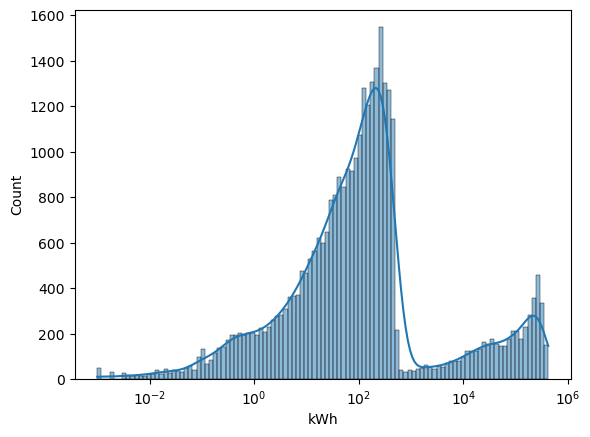

In [6]:
df_bearspaw = df_production[df_production["location"] == "Bearspaw"]
display( df_bearspaw[["kWh"]].describe() )

_ = sns.histplot(data = df_bearspaw, x = "kWh", log_scale=True, kde = True)

Notice that the data are log-scaled. Seems like a subset of the data are **several orders of magnitude larger than the rest** - how can that be!?

After some digging I eventually found out the reason - **the data after 25 September 2023 suddenly increase by 3 orders of magnitude!** This appears to be because the units changed from *kilo*-watts to *watts*, which would explain the sudden increase. This is just my best guess as to what's going on here, but if you simply divide the data by 1000 (after 25 September 2023) you get numbers which make sense. 

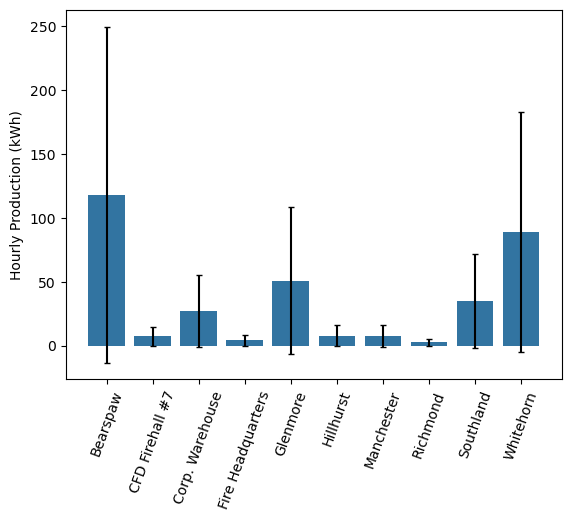

In [7]:
# Data after 25 September 2023 changed to units of Watts instead of kW
date_start = pd.to_datetime('2023-09-25')
date_end = pd.to_datetime('2025-12-31')
# Create mask for rows between start and end dates
mask = (df_production.index >= date_start) & (df_production.index <= date_end)
# Apply the conversion
df_production.loc[mask, 'kWh'] = df_production.loc[mask, 'kWh'] / 1000

# recompute the mean and std
df_mean_output = df_production[["location","kWh"]].groupby("location").mean()
# add some error bars for the standard dev
df_std_output = df_production[["location","kWh"]].groupby("location").std()
err_data = list(df_std_output["kWh"])
data = list(df_mean_output["kWh"])

sns.barplot(x = keys, y = data)

_ = plt.xticks(rotation=70)
_ = plt.ylabel('Hourly Production (kWh)')

conc2 = np.arange(0, len(keys))
width = .25
add = [-1*width, 0 , width, -1*width, 0 , width, -1*width, 0 , width,]
x = np.array(conc2)

_ = plt.errorbar(x = x, y = data,
            yerr=err_data, fmt='none', c= 'black', capsize = 2)

Ok the variablity is still really high, but this makes more sense. Remember this is hourly data, so we expect a lot of variability (high values during midday, with values near zero in early morning/ late afternoon). We are also in Canada so the difference between summer and winter will be quite dramatic! 

Next lets take a look at how far apart the different locations are. We'll see why this is important in a moment.

I've extracted the addresses from the data and plotted them out on google maps, take a look:
![map of locations](map_of_locations_with_scale.png "Map of Locations")

So the locations are roughly 10 to 15 km away from each other. This can help us decide what kind of weather model to use to get the best results. In particular, the *resolution* of the weather model is important here. If we use a weather model with a resolution of ~10 km or larger, then getting forecast data for each location will not really improve performance . This is because the data will likely just be the same for every location, since the weather model treats everything in a 10 km radius as "the same" (check out [this](https://climateextremes.org.au/what-does-climate-model-resolution-mean/) page for an explainer on model resolution).

On the other hand, if we can get our hands on higher resolution data, it would make sense to get data specific to each location.

# PART B: Weather Data

Now that we have a sense of the data we'd like to model (i.e. predict), its time to get a set of features that will allow us to accurately predict solar energy production. For this I turned to the free [Open-Meteo](https://open-meteo.com) API, an amazing resource that provides easy access to pretty much all the weather data you could want!

Browsing around I settled on this list of **weather features**:
- Shortwave radiation (basically how much energy is reaching the Earth's surface)
- Temperature
- Relative Humidity
- Rainfall amount
- Snowfall amount
- Cloudy cover percentage

I was able to download these for the period covering our solar production data, i.e. 2018 to 2024. The **resolution of the historical weather data is ~9 km, while the forecast data is ~2.5 km**, so I extracted data for each location. 

Why these features? Apart from the obvious ones (clouds, snow, radiation), temperature is known to affect solar panel performance, as does the amount of water vapour in the air. I reasoned that rain would further decrease performance, due to the presence of a layer of water over the panel. 

Lets take a look at the resulting dataset.

In [8]:
# historical weather data
# ERA5 is the weather model used to reconstruct past weather conditions, taking into account real observations
df_weather = pd.read_csv('../data/hourly_weather_data_ERA5_all_locs.csv') 

df_weather.head()

,Unnamed: 0,date,temperature_2m,relative_humidity_2m,rain,snowfall,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,shortwave_radiation,location
0,0,2018-01-01 00:00:00,-32.478000,75.643970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fire Headquarters
1,1,2018-01-01 01:00:00,-30.178000,78.348980,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fire Headquarters
2,2,2018-01-01 02:00:00,-27.877998,74.393974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fire Headquarters
3,3,2018-01-01 03:00:00,-26.477999,73.287240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fire Headquarters
4,4,2018-01-01 04:00:00,-25.078000,72.224490,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Fire Headquarters


It will be useful at this point to merge the solar production data with this weather data so we can compare them, and use the weather data to model the `kWh` solar production.

For convience I will use a preprocessing class implemented in this repo to achieve this (check out the methods in `preprocessing.py` to see how this is done).

In [9]:
# production data from city of calgary
df_production = pd.read_csv('../data/Solar_Energy_Production_20250219.csv')


preprop = preprocessing.Preprocessing(df_production=df_production,
                                            df_weather=df_weather)
# cleans up the production data
df_production = preprop.misc_production()

# some cleaning of the weather data
df_weather = preprop.misc_weather()

# slice data to 2018 to end 2024
df_production = preprop.slice_by_date(df=df_production, end_date='20241231')
df_weather = preprop.slice_by_date(df=df_weather, end_date='20241231')

df_merged = preprop.merge(df_production, df_weather, merge_dim = ['date','location'] )

df_merged.head()

,id,address,kWh,public_url,installationDate,uid,location,Unnamed: 0,temperature_2m,relative_humidity_2m,rain,snowfall,cloud_cover,cloud_cover_low,cloud_cover_mid,cloud_cover_high,shortwave_radiation
date,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,577650,11444 Bearspaw Dam RD NW,1.317,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 00:00:00,Bearspaw,0,-25.7815,71.39783,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 01:00:00,577650,11444 Bearspaw Dam RD NW,1.324,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 01:00:00,Bearspaw,1,-24.2815,70.41304,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 02:00:00,577650,11444 Bearspaw Dam RD NW,1.331,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 02:00:00,Bearspaw,2,-23.5815,71.55348,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 03:00:00,577650,11444 Bearspaw Dam RD NW,1.361,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 03:00:00,Bearspaw,3,-23.0315,72.00295,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2018-01-01 04:00:00,577650,11444 Bearspaw Dam RD NW,1.386,https://monitoringpublic.solaredge.com/solared...,2017/10/31,5776502018-01-01 04:00:00,Bearspaw,4,-22.6315,71.10968,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### To get a sense of how well our features map onto our target variable, lets visualize the relationship between the various features.

First the most obvious `kWh` vs. `shortwave_radiation`. To get more out of this graph we can also add a 3rd variable, in the case `temperature_2m`.

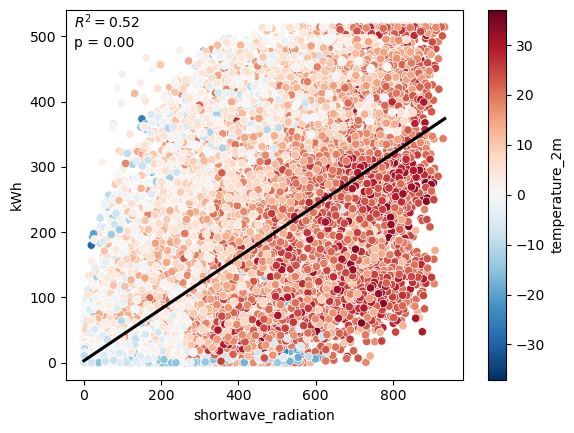

In [10]:
# here using another plotting method found in this repo, 
# the default behaviour plots radiation against kWh output
plot.scatter(dataframe=df_merged, color_var='temperature_2m',
             location='Bearspaw')

Here we can see the relationship between how much energy is reaching the surface (i.e. `shortwave_radiation`), and the output of the panels at the biggest array in the city, Bearspaw. Each point is also shaded according to the temperature at the time the output was recorded. 

My initial expectation was that this relationship would be much stronger, but the radiation data only accounts for ~50% of the variabiliy in output (at least at this location - it is higher at other locations). How can this be?

Well, there are several factors probably at play here:
1. **Temperature** - the panels tend to operate better at lower temperatures. Notice how the darker red colors tend to be in the lower right, while lighter red and blues are in the upper left. 

2. **Ice** - one expection to what I just said is the distinct line of blue dots along the bottom edge of the plot. These are times when the power output was anomalously low, given how much energy was available from the sun. An obvious explanation is that ice happened to form on the panels in these cases, thus blocking the sun. 

3. **Aspect** - a fancy way of saying it matters which way the panels are facing. For example, it could be really sunny in the morning, but if the panels are facing west toward the afternoon sun, then you won't get much power obviously. 

4. **Shading** - depending on where the panels are installed, they may get shaded by trees, other buildings etc. 

5. **Maximum output** - The horizontal line of points along the top edge of the plot suggests that the maximum output for the Bearspaw array is ~520 kWh. This upper limit reduces our R-squared value, since more power from the sun simply can't produce more power out the panels. 

6. **Other environmental factors** - by this I just mean the other weather data like rain, clouds, snow etc.

Lets take a look at some of those other environmental factors, starting with the effect of humidity and cloud cover. We'll look at Whitehormn (the 2nd largest array) to keep things interesting. 


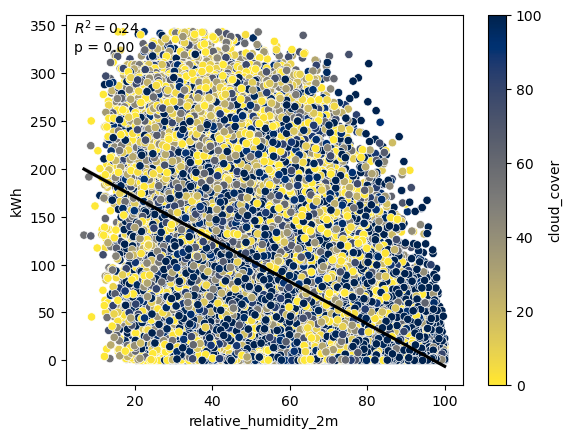

In [23]:
plot.scatter(dataframe=df_merged, location='Whitehorn',
                 x = 'relative_humidity_2m', color_var='cloud_cover',
                 colormap='cividis_r')

As expected, the higher the humidity, the lower the output. This is because water vapour in the air disperses the sun's energy, and water can actually condense on the surface of the panels, thus futher impacting performance. The impact is not huge though, so this is a 2nd order feature compared to `shortwave_radiation` and `temperature_2m`.

Interestingly, cloud cover seems to be unrelated to output in this dataset. This could be due to several factors:
1. **Spatial Resolution** - clouds are one of the hardest variables to predict for a weather model, which is closely related to the spatial resolution (i.e. the size of the grid boxes) of the model. So it could be that the cloud cover data is simply not accurate enough to constain our output. The fact that Calgary is built right next to the Rocky Mountains makes things even harder, because the mountainous terrain makes predictions even worse. 

2. **Temporal Resolution** - the cloud cover data we are using is the average of the cover over the past hour. However, there could be significant fluctuations even within 1 hour, thus further degrading the predictive power. 

3. **Time of day** - cloud cover only makes a difference when there is actually a significant amount of power coming from the sun. So the fact that its clouldy in the early morning or late afternoon would not make much difference (data for night-time have been largely removed in the original dataset from the city).

**One big factor is still missing though - DUST**

Check out this figure of the annual mean power output, compared to the annual mean `shortwave_radiation` at the **Bearspaw** location:

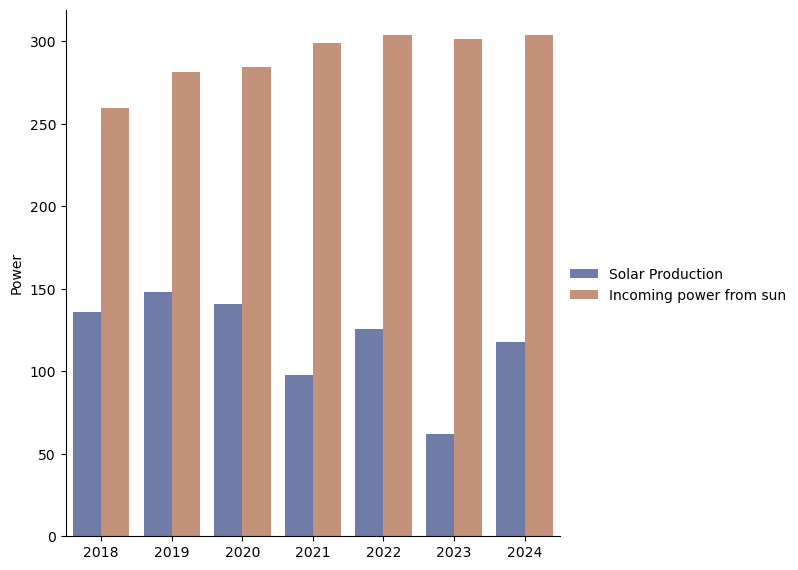

In [8]:
plot.bar_compare_years(df = df_merged, loc='Bearspaw')

You can see that production in 2023 is really low, even though the incoming power in that year is one of the higher values. Compare that to 2018, which has the lowest incoming power, but relatively high production by the array. 

The most pluasible explanation for this is a common issue with solar panels - they get dirty over time and this affects performance. This will further limit our ability to model solar output, since we cannot know how "clean" the panels are. 
This seems to be more of an issue at some locations, but less at others. If we look at **Whitehorn**, the 2nd largest array, the year-to-year variability is much lower:

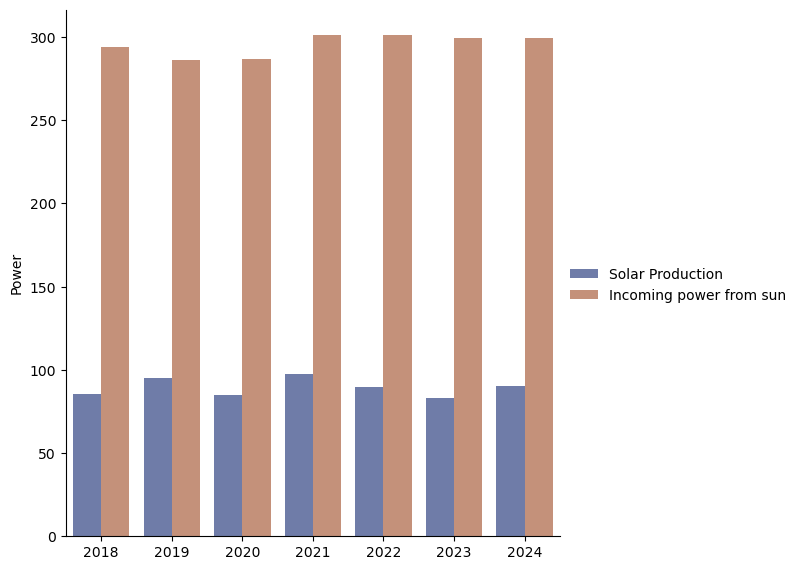

In [9]:
plot.bar_compare_years(df = df_merged, loc='Whitehorn')

It could be that this location is less prone to dust, or actually gets cleaned more often, no way to tell at this stage. At our 3rd largest array, **Glenmore**, we can see a clear degradation of performance from 2021 to 2024, suggesting an accumulation of dirt:

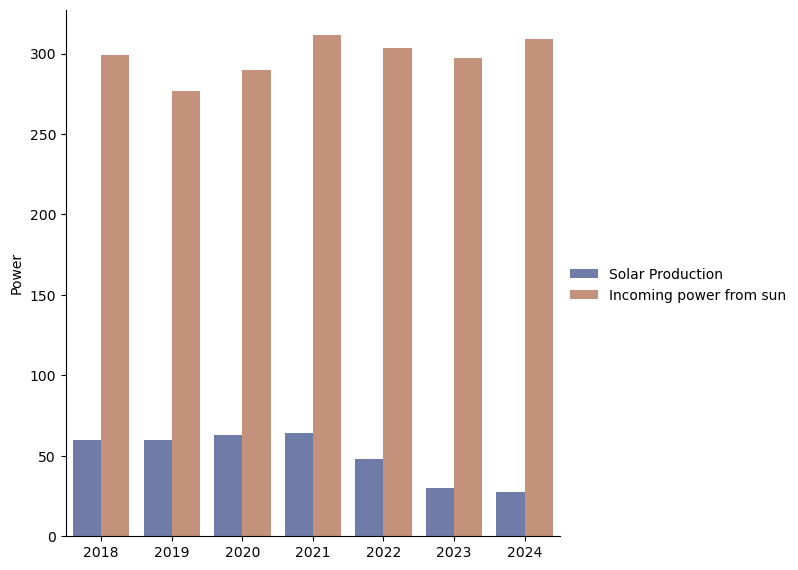

In [10]:
plot.bar_compare_years(df = df_merged, loc='Glenmore')

## PART C: Modelling

Now we finally get to part where we try to model the solar production for the City of Calagary!

A first and important choice we should make is whether we model the **total production** across all 10 locations, or if we create a **separate model for each location**. After some playing around I have settled on modelling each location separately, based on what we have discussed above in parts A and B.

Since each location will have its own unique set of characteristics (aspect, shading, dust etc.) this approach should yield better results than trying to model the total output. With this approach I introduced some additional features to help the model learn the unique aspect and shading conditions at each location:
- **Hour** - simply the hour from 0 to 23.
- **Day of year** - from 1 to 366.
- **Month** - from 1 to 12.

With these features the model could learn, for example, that one location will only reach maximum output in early June, between 1pm and 3pm (if its sunny of course). Another location might perform best in late July in the morning, due to the way it faces and the surrounding trees/ buildings.

Here I'll show results from two models:
1. **Linear regression** with polynomial features.
2. Boosted ensemble of trees using **XGBoost**.

### Linear Model

Here I used `scikit-learn` to create a `pipeline` with the following steps:
- **Feature selection** - selecting the N best features
- **Feature scaling** - getting everything on a similar scale to ease model fitting
- **Polynomial Features** - creating an n-degree polynomial from the selected features
- **Regularization** - to prevent overfitting

Finally, I used `GridSearchCV` to find the optimal set of hyperparameters.

Lets take a look at the results!

We'll focus on the **top 3 locations: Bearspaw, Whitehorn and Glenmore**. We'll compare the predictions verus the labels in the **test set**.


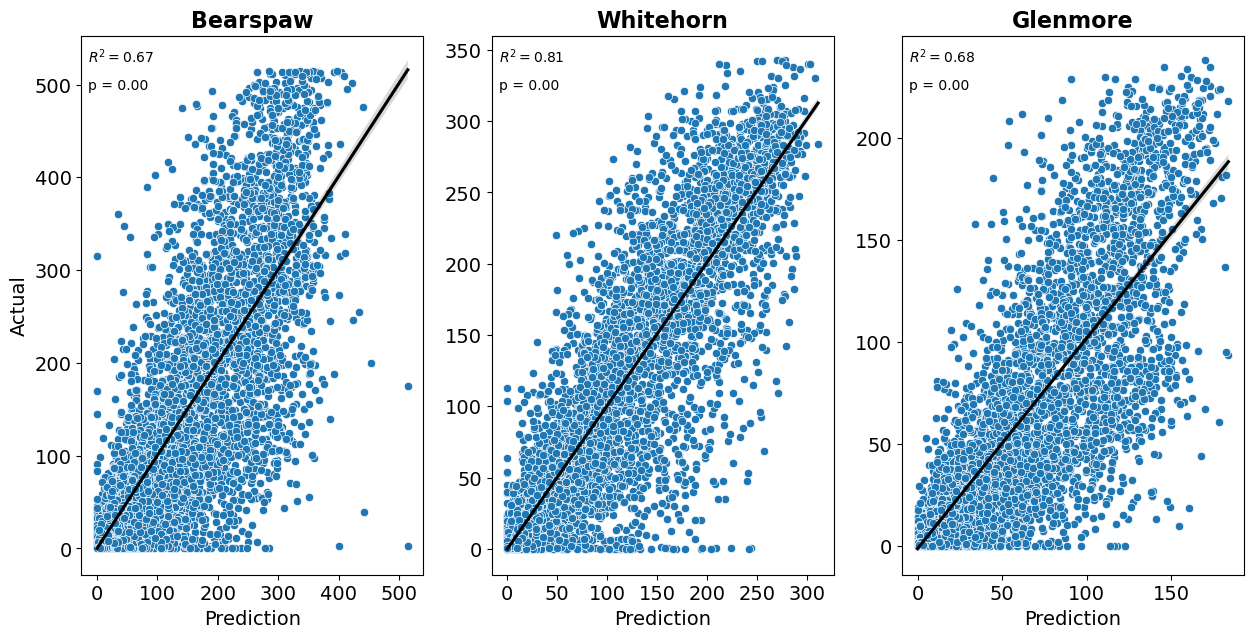

In [12]:
with open('../trained_model_data/trained_models_linear.pkl', 'rb') as pickle_file:
    linear_models = pickle.load(pickle_file)

df_x_test_linear = pd.read_csv('../trained_model_data/x_test_linear.csv')
df_y_test_linear = pd.read_csv('../trained_model_data/y_test_linear.csv')
# load the max output at each location
df_max_out = pd.read_csv('../data/max_output_each_location.csv')



locs = ['Bearspaw','Whitehorn','Glenmore']
fig, axs = plt.subplots(1, 3, figsize = (15,7) )

for i,loc in enumerate(locs):
    dfp = plot.get_model_preds(x_test = df_x_test_linear, y_test = df_y_test_linear,
                               model = linear_models,
                              loc = loc, df_max=df_max_out)

    plot.scatter(dataframe=dfp,  x = 'Prediction', y = 'Actual', axes = axs[i])
    axs[i].set_title(loc, fontsize = 16, fontweight = 'bold')
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        axs[i].set_xticklabels( axs[i].get_xticklabels() , fontsize = 14 )
        axs[i].set_yticklabels( axs[i].get_yticklabels() , fontsize = 14 )
        axs[i].set_xlabel('Prediction', fontsize = 14)
        if i == 0:
            axs[i].set_ylabel('Actual', fontsize = 14)
        else:
            axs[i].set_ylabel('')

Considering all of the limitations we have discussed, this is not bad for a simple linear model. 

We can try to get more insight into the model's shortcomings by **adding `shortwave_radiation` as a third variable** to the scatter plot, as before.


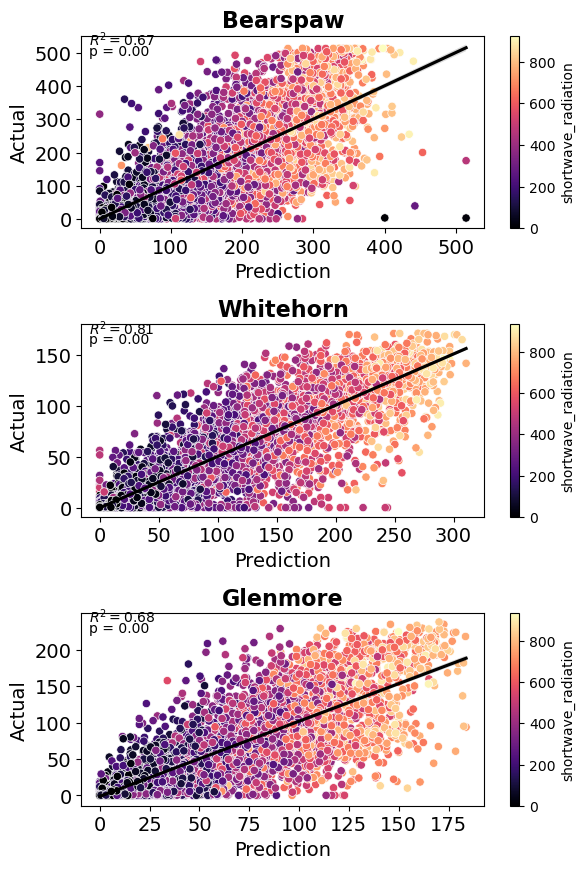

In [13]:
fig, axs = plt.subplots(3, 1, figsize = (6.5,10) )
shading_var = 'shortwave_radiation'
color_map = 'magma'
locs = ['Bearspaw','Whitehorn','Glenmore']

for i,loc in enumerate(locs):
    dfp = plot.get_model_preds(x_test = df_x_test_linear, y_test = df_y_test_linear,
                               model = linear_models, hue_var = shading_var,
                              loc = loc, df_max=df_max_out)

    plot.scatter(dataframe=dfp,  x = 'Prediction', y = 'Actual', axes = axs[i],
                color_var=shading_var, colormap=color_map)
    axs[i].set_title(loc, fontsize = 16, fontweight = 'bold')
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        axs[i].set_xticklabels( axs[i].get_xticklabels() , fontsize = 14 )
        axs[i].set_yticklabels( axs[i].get_yticklabels() , fontsize = 14 )
        axs[i].set_xlabel('Prediction', fontsize = 14)
        axs[i].set_ylabel('Actual', fontsize = 14)
            
plt.subplots_adjust(hspace=0.5)

**Unfortunately, this doesn't reveal any systematic patterns** - for both under and over predicted output `shortwave_radiation` spans the full range of values. In other words, sometimes the output is really low, despite there being plenty of sun, and other times the output is unexpectly high for the amount of sun there is. 

You can play around with the `shading_var` to look at the other variables - but nothing reveals any strong patters. I concluded that there are just some **fundamental limitations to how well we can expect to predict this data**. 

### XGBoost 

I used a very similar approach here, also employing `GridSearchCV` to estimate the optimal hyperparameters.

As before, lets visualise our model performance.

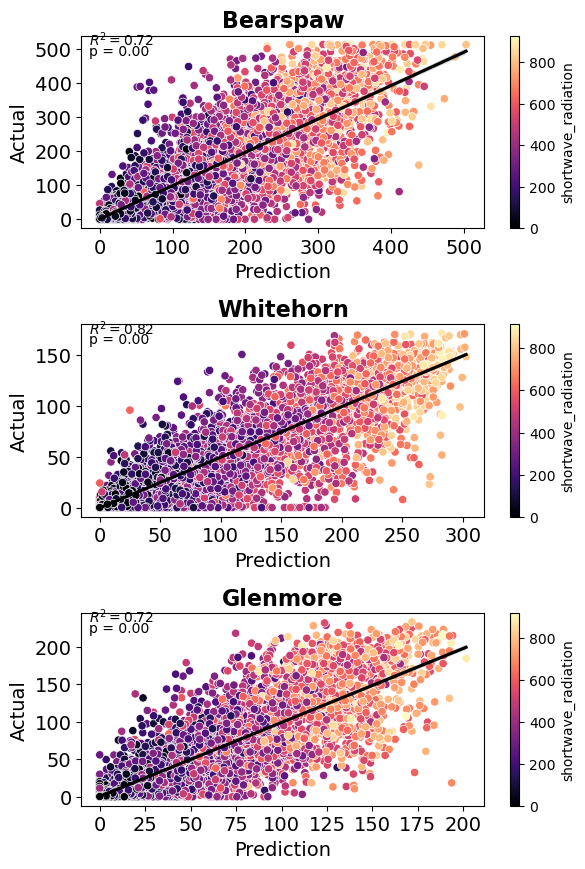

In [23]:
with open('../trained_model_data/trained_models_xgboost.pkl', 'rb') as pickle_file:
    xgb_models = pickle.load(pickle_file)

df_x_test_xgb = pd.read_csv('../trained_model_data/x_test_xgb.csv')
df_y_test_xgb = pd.read_csv('../trained_model_data/y_test_xgb.csv')
# load the max output at each location
df_max_out = pd.read_csv('../data/max_output_each_location.csv')

locs = ['Bearspaw','Whitehorn','Glenmore']
fig, axs = plt.subplots(3, 1, figsize = (6.5,10) )

shading_var = 'shortwave_radiation'
color_map = 'magma'

for i,loc in enumerate(locs):
    dfp = plot.get_model_preds(x_test = df_x_test_xgb, y_test = df_y_test_xgb,
                               hue_var = shading_var,
                               model = xgb_models,
                              loc = loc, df_max=df_max_out)

    plot.scatter(dataframe=dfp,  x = 'Prediction', y = 'Actual', axes = axs[i],
                color_var=shading_var, colormap=color_map)
    axs[i].set_title(loc, fontsize = 16, fontweight = 'bold')
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        axs[i].set_xticklabels( axs[i].get_xticklabels() , fontsize = 14 )
        axs[i].set_yticklabels( axs[i].get_yticklabels() , fontsize = 14 )
        axs[i].set_xlabel('Prediction', fontsize = 14)
        axs[i].set_ylabel('Actual', fontsize = 14)

            
plt.subplots_adjust(hspace=0.5)

plt.savefig('scatter_calgary_top3_shortwave_in_color.png', 
            format = 'png', dpi = 150, bbox_inches = 'tight',
        facecolor = 'white')

We see a clear improvement in performance using this model, but less than might be expected. 

In order to really improve our model beyond this point, we could look into the following:
- Higher resolution historical radiaition data.
- Access to the cleaning schedule of the panels (create a "days since cleaning" feature).
- Create a "days since last rain" feature, which might help with the dirt issue. 